## **Loading the dataset Tiny_imagenet**

1. load using numpy and torch
2. the input is 64x64 pixel coloured image (i.e. 64x64x3 size input)

In [64]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# to avoid kernel dying because of library dependency issues


In [65]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x))     # This flattens the image from (3, 64, 64) to (12288,)
])

train_dataset = datasets.ImageFolder(root=r'C:\Users\kumar\Desktop\DL_Lab\Lab1\Lab1_3\tiny-imagenet\train', transform=transform)
val_dataset = datasets.ImageFolder(root=r'C:\Users\kumar\Desktop\DL_Lab\Lab1\Lab1_3\tiny-imagenet\val', transform=transform)
test_dataset = datasets.ImageFolder(root=r'C:\Users\kumar\Desktop\DL_Lab\Lab1\Lab1_3\tiny-imagenet\test', transform=transform)

# 4. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=64,shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

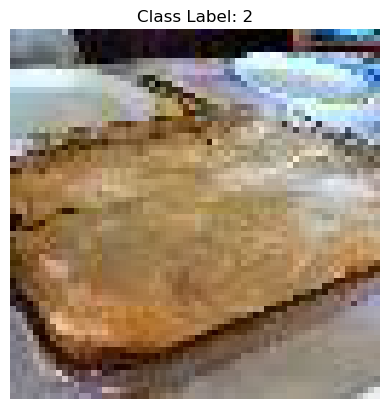

In [66]:
import matplotlib.pyplot as plt
#Load a single image to see if everything was right

#single batch from your training loader
dataiter = iter(train_loader)
images, labels = next(dataiter)
#flattened (shape: 12288)
sample_image = images[0]
sample_label = labels[0]

#(Height, Width, Channels) for Matplotlib -> (64, 64, 3)
viewable_image = sample_image.view(3, 64, 64).permute(1, 2, 0).numpy()

# 5. Display
plt.imshow(viewable_image)
plt.title(f"Class Label: {sample_label.item()}")
plt.axis('off')
plt.show()

## **Training 2 different models**
1. We aim to make 2 similar models with different architechture, with different activation function, with the aim to explore the vanishing gradients problem.
2. we will also look at the weight updates in between training to quantify the above problem.

In [67]:
import torch.nn as nn
class Tiny_imagenet_modelA(nn.Module):
    def __init__(self,in_d=12288,hidden_d=512,out_d=10):
        super(Tiny_imagenet_modelA,self).__init__()
        self.layers = nn.ModuleList() # list to manage the large num of layers

        self.layers.append(nn.Linear(in_d,hidden_d))
        for i in range(7):
            self.layers.append(nn.Linear(hidden_d,hidden_d))
        self.layers.append(nn.Linear(hidden_d,out_d))
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):
        for layer in self.layers:
            x = self.sigmoid(layer(x))
        return x

class Tiny_imagenet_modelB(nn.Module):
    def __init__(self, in_d=12288, hidden_d=512, out_d=10):
        super(Tiny_imagenet_modelB, self).__init__()
        self.layers = nn.ModuleList()
        self.bns = nn.ModuleList() # Batchnorm List

        self.layers.append(nn.Linear(in_d, hidden_d))
        self.bns.append(nn.BatchNorm1d(hidden_d))

        # 7 Hidden Layers
        for _ in range(7):
            self.layers.append(nn.Linear(hidden_d, hidden_d))
            self.bns.append(nn.BatchNorm1d(hidden_d))

        # Output Layer
        self.output_layer = nn.Linear(hidden_d, out_d)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Iterate through hidden layers with BN and ReLU
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = self.bns[i](x)  # Apply BN
            x = self.relu(x)    # Apply ReLU
        
        # Final output without activation
        return self.output_layer(x)

In [68]:
# model A training
import torch.optim as optim
# Initialize Model A
modelA = Tiny_imagenet_modelA()
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizerA = optim.Adam(modelA.parameters(), lr=0.001)

# Initialize these before your loops
losses_A= []

# List to store gradients
grad_A = []
for epoch in range(epochs):
    modelA.train()
    for imgs,lab in train_loader:
        outputA = modelA.forward(imgs)
        loss = criterion(outputA,lab)
        optimizerA.zero_grad()
        loss.backward()

        inLayerGrads = modelA.layers[0].weight.grad
        normA = torch.norm(inLayerGrads).item()
        grad_A.append(normA)
        optimizerA.step()
        losses_A.append(loss.item()) 
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')



KeyboardInterrupt: 

In [ ]:
#model b training
modelB= Tiny_imagenet_modelB()
optimizerB = optim.Adam(modelB.parameters(), lr=0.001)
epochs = 16
# List to store gradients
grad_B = []
losses_B= []
for epoch in range(epochs):
    modelA.train()
    for imgs,lab in train_loader:
        outputB = modelB.forward(imgs)
        loss = criterion(outputB,lab)
        optimizerB.zero_grad()
        loss.backward()

        inLayerGrads = modelB.layers[0].weight.grad
        normB = torch.norm(inLayerGrads).item()
        grad_B.append(normB)
        optimizerB.step()
        losses_B.append(loss.item()) 
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/16], Loss: 1.6458
Epoch [2/16], Loss: 1.6631
Epoch [3/16], Loss: 1.7054
Epoch [4/16], Loss: 1.5844
Epoch [5/16], Loss: 1.4129
Epoch [6/16], Loss: 1.1522
Epoch [7/16], Loss: 0.9821
Epoch [8/16], Loss: 1.1638
Epoch [9/16], Loss: 1.2812
Epoch [10/16], Loss: 0.9935
Epoch [11/16], Loss: 1.3134
Epoch [12/16], Loss: 0.7620
Epoch [13/16], Loss: 0.8306
Epoch [14/16], Loss: 0.8882
Epoch [15/16], Loss: 0.5438
Epoch [16/16], Loss: 0.3264


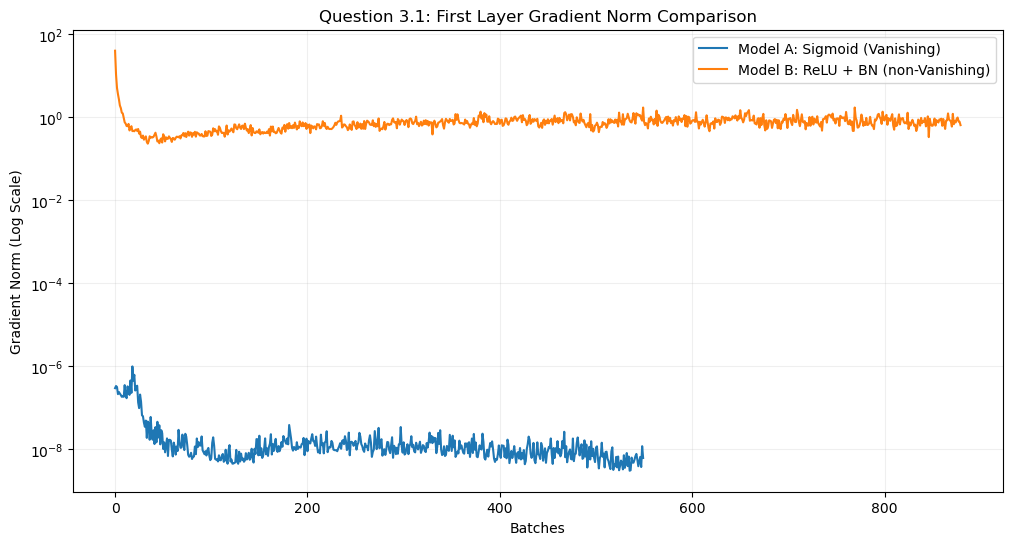

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plotting Gradient Norms
plt.plot(grad_A, label='Model A: Sigmoid (Vanishing)')
plt.plot(grad_B, label='Model B: ReLU + BN (non-Vanishing)')

# Use a Log scale because Sigmoid gradients are often orders of magnitude smaller
plt.yscale('log') 
plt.title('Question 3.1: First Layer Gradient Norm Comparison')
plt.xlabel('Batches')
plt.ylabel('Gradient Norm (Log Scale)')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

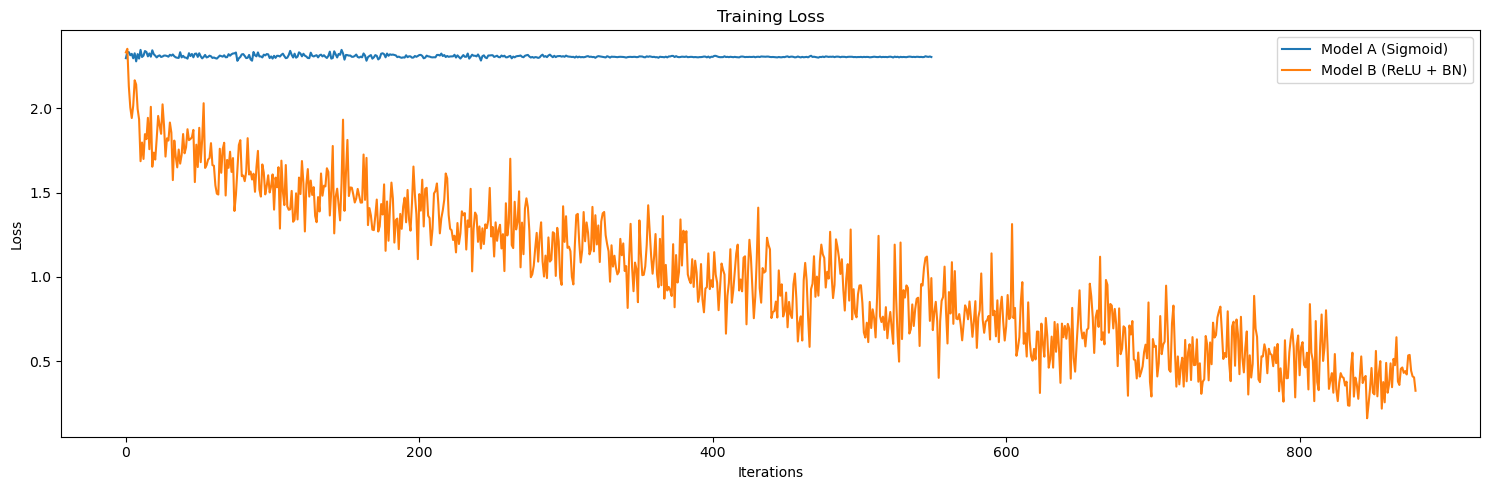

In [ ]:
fig, ax1= plt.subplots(1, 1, figsize=(15, 5))

# Loss Plot
ax1.plot(losses_A, label='Model A (Sigmoid)')
ax1.plot(losses_B, label='Model B (ReLU + BN)')
ax1.set_title('Training Loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.legend()


plt.tight_layout()
plt.show()

In [ ]:
def calculate_accuracy(model, loader,device = "cpu"):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradients needed for evaluation
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            
            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100 * correct / total
    return accuracy
# At the end of Model A training loop
val_acc_A = calculate_accuracy(modelA, test_loader)
print(f"Model A Val Accuracy: {val_acc_A:.2f}%")

# At the end of Model B training loop
val_acc_B = calculate_accuracy(modelB, test_loader)
print(f"Model B Val Accuracy: {val_acc_B:.2f}%")

Model A Val Accuracy: 10.00%
Model B Val Accuracy: 38.10%


## **Ablation Study**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def calculate_accuracy(model, loader, device='cpu'):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

class TinyImageNetAblation(nn.Module):
    def __init__(self, in_d=12288, hidden_d=512, out_d=10, use_dropout=True):
        super(TinyImageNetAblation, self).__init__()
        self.layers = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.use_dropout = use_dropout
        
        # Layer 1
        self.layers.append(nn.Linear(in_d, hidden_d))
        self.bns.append(nn.BatchNorm1d(hidden_d))
        
        # 7 Hidden Layers
        for _ in range(7):
            self.layers.append(nn.Linear(hidden_d, hidden_d))
            self.bns.append(nn.BatchNorm1d(hidden_d))
            
        self.output_layer = nn.Linear(hidden_d, out_d)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2) # Standard Dropout rate

    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = self.bns[i](x)
            x = self.relu(x)
            if self.use_dropout:
                x = self.dropout(x)
        return self.output_layer(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
epochs = 12 
experiments = {
    "Baseline": {"dropout": True, "lr": 0.001, "opt": "Adam"},
    "No Dropout": {"dropout": False, "lr": 0.001, "opt": "Adam"},
    "High LR": {"dropout": True, "lr": 0.01, "opt": "Adam"},
    "Vanilla SGD": {"dropout": True, "lr": 0.001, "opt": "SGD"}
}

results_table = {}

for name, cfg in experiments.items():
    print(f"\n--- Running Experiment: {name} ---")
    model = TinyImageNetAblation(use_dropout=cfg["dropout"]).to(device)

    if cfg["opt"] == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=cfg["lr"])
    else:
        optimizer = optim.SGD(model.parameters(), lr=cfg["lr"])
        
    # Training Loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for imgs, labs in train_loader:
            imgs, labs = imgs.to(device), labs.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_acc = calculate_accuracy(model, train_loader, device)
        test_acc = calculate_accuracy(model, test_loader, device)
        print(f"Epoch {epoch+1} | Loss: {running_loss/len(train_loader):.3f} | Train Acc: {train_acc:.2f}% | Val Acc: {test_acc:.2f}%")
        
    results_table[name] = test_acc



--- Running Experiment: Baseline ---
Epoch 1 | Loss: 1.965 | Train Acc: 32.14% | Val Acc: 29.90%
Epoch 2 | Loss: 1.725 | Train Acc: 37.51% | Val Acc: 35.00%
Epoch 3 | Loss: 1.622 | Train Acc: 40.86% | Val Acc: 36.00%
Epoch 4 | Loss: 1.539 | Train Acc: 46.54% | Val Acc: 36.80%
Epoch 5 | Loss: 1.460 | Train Acc: 50.46% | Val Acc: 41.20%
Epoch 6 | Loss: 1.376 | Train Acc: 51.54% | Val Acc: 39.10%
Epoch 7 | Loss: 1.324 | Train Acc: 57.63% | Val Acc: 41.60%
Epoch 8 | Loss: 1.237 | Train Acc: 43.63% | Val Acc: 31.40%
Epoch 9 | Loss: 1.147 | Train Acc: 62.97% | Val Acc: 39.30%
Epoch 10 | Loss: 1.135 | Train Acc: 51.46% | Val Acc: 35.40%
Epoch 11 | Loss: 1.041 | Train Acc: 55.03% | Val Acc: 35.00%
Epoch 12 | Loss: 1.004 | Train Acc: 66.74% | Val Acc: 41.70%

--- Running Experiment: No Dropout ---
Epoch 1 | Loss: 1.837 | Train Acc: 37.74% | Val Acc: 35.60%
Epoch 2 | Loss: 1.596 | Train Acc: 45.49% | Val Acc: 38.80%
Epoch 3 | Loss: 1.487 | Train Acc: 42.89% | Val Acc: 36.60%
Epoch 4 | Loss: 1.3

KeyboardInterrupt: 